# Visualizions
## Visualize sidewalk polygons

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils

In [2]:
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Create reader for BGT sidewalk part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad_demo.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

(485099.0, 485151.0)

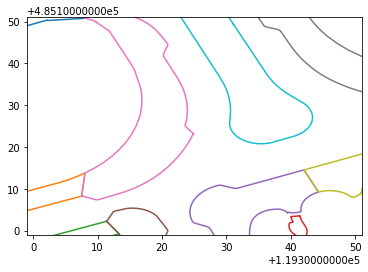

In [3]:
for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y)
    
# Get current axis and then set its limits
ax = plt.gca()
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/sidewalk.png')

## 2D Visualization of obstacles

In [4]:
import pandas as pd
from pathlib import Path
import ast
from shapely.geometry import Polygon

def get_obstacles():
    """
    Return a list of polygons representing each of the roads found in
    the area represented by the given CycloMedia tile-code.
    """
    obstacles = [ast.literal_eval(poly) for poly in df_obstacles.obstacle.values]
    poly_obstacles = [Polygon(rds)
                      for rds in obstacles]
    return poly_obstacles

bgt_obstacle_file = '../datasets/bgt/bgt_obstacle_demo.csv'
df_obstacles = pd.read_csv(Path(bgt_obstacle_file))
obstacles = get_obstacles()

(485099.0, 485151.0)

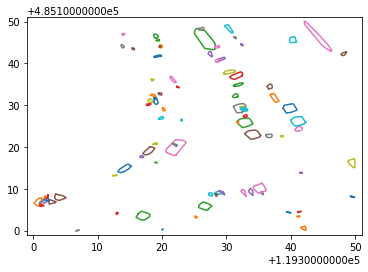

In [5]:
for obstacle in obstacles:
    x,y = obstacle.exterior.xy
    plt.plot(x,y)
    
# Get current axis and then set its limits
ax = plt.gca()
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/obstacles.png')

## Plot exterior and interior polygons

(485099.0, 485151.0)

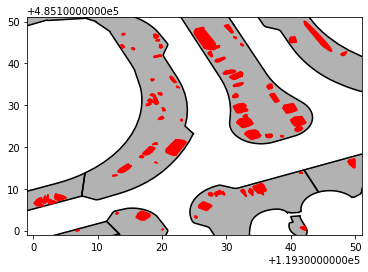

In [6]:
# Read sidewalk with obstacles as interiors
df = gpd.read_file('../datasets/sidewalk_with_obstacles.shp')

# Plot the result
for index, row in df.iterrows():
    sidewalk_obstacles = row['geometry']
    x, y = sidewalk_obstacles.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)

    plt.plot(x, y, c="black")
    interiors = sidewalk_obstacles.interiors
    for interior in interiors:
        x, y = interior.xy
        plt.fill(x, y, c="red")
        plt.plot(x, y, c="red")
    
# Get current axis and then set its limits
ax = plt.gca()
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/sidewalk_with_obstacles.png')